# Generalised Gamma Process (GGP)

Generalised gamma process with intensity
$\lambda(w) = \frac{\alpha}{\Gamma(1-\sigma)} w^{(-1-\sigma)} \exp(-\tau w) $

In [1]:
from operator import itemgetter

import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sgp import GGPrnd, BSgraphrnd, GGPgraphrnd
from sgp.GraphUtil import compute_growth_rate, degree_distribution, degree_one_nodes

%matplotlib inline

##  Intensity plot of GGP measure

We plot the intensity function to give some intuition about GGP measure.

In [2]:
def levy_intensity(w, alpha, sigma, tau):
    return alpha/gamma(1.-sigma) * w**(-1.-sigma) * np.exp(-tau*w)

Typically, sigma is the most important parameter of GGP of which controls the number of clusters in mixture models.

Reference: Lijoi, A., Mena, R. H., & Prunster, I. (2007). Controlling the reinforcement in Bayesian non-parametric mixture models. Journal of the Royal Statistical Society. Series B: Statistical Methodology, 69(4), 715–740. http://doi.org/10.1111/j.1467-9868.2007.00609.x

In [3]:
alpha = 20.
sigma = 0.1
tau = 1.
intensity = levy_intensity(np.linspace(0,0.001,1000), alpha, sigma, tau)

sigma = 0.5
intensity2 = levy_intensity(np.linspace(0,0.001,1000), alpha, sigma, tau)

sigma = 0.9
intensity3 = levy_intensity(np.linspace(0,0.001,1000), alpha, sigma, tau)

#finite activity case
sigma = -1.
intensity4 = levy_intensity(np.linspace(0,10,1000), alpha, sigma, tau)
sigma = -2.5
intensity5 = levy_intensity(np.linspace(0,10,1000), alpha, sigma, tau)
sigma = -5.
intensity6 = levy_intensity(np.linspace(0,10,1000), alpha, sigma, tau)

## Infinite activity case

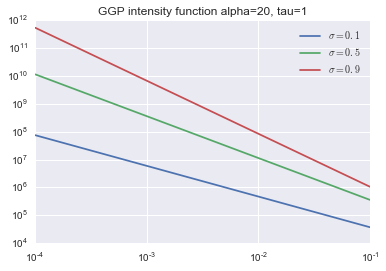

In [4]:
plt.loglog(np.linspace(0,0.1,1000)[1:], intensity[1:], label='$\sigma = 0.1$')
plt.loglog(np.linspace(0,0.1,1000)[1:], intensity2[1:], label='$\sigma = 0.5$')
plt.loglog(np.linspace(0,0.1,1000)[1:], intensity3[1:], label='$\sigma = 0.9$')
#plt.ylim([0,1e8])
plt.legend()
plt.title('GGP intensity function alpha=20, tau=1')

As the sigma is more closer to 1, it gives more weight to the tail of the intensity.

## Finite-activity case

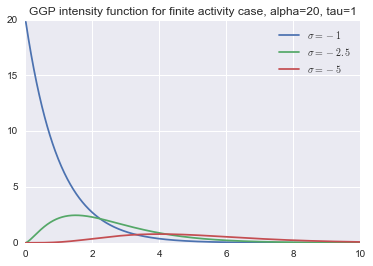

In [5]:
plt.plot(np.linspace(0,10,1000)[1:], intensity4[1:], label='$\sigma = -1$')
plt.plot(np.linspace(0,10,1000)[1:], intensity5[1:], label='$\sigma = -2.5$')
plt.plot(np.linspace(0,10,1000)[1:], intensity6[1:], label='$\sigma = -5$')
plt.legend()
plt.title('GGP intensity function for finite activity case, alpha=20, tau=1')

# Simulating Random Measure Drawn from GGP

A random measure is drawn from GGP:

$\mu \sim \text{GGP}(\alpha, \sigma, \tau)$

$\mu = \sum_{i=1}^{\infty} w_i \delta_{\theta_i}$

It's not possible to simulate an infinite dimensional GGP. We use an adaptive thinning method proposed by Favaro and Teh.

Reference: Favaro, S., & Teh, Y. W. (2013). MCMC for Normalized Random Measure Mixture Models. Statistical Science, 28(3), 335–359. http://doi.org/10.1214/13-STS422

In [6]:
alpha = 20.
tau = 1.
sigma = 0.5

w, T = GGPrnd(alpha, sigma, tau)
thetas = np.random.random(size = w.size)*alpha

number of atoms:

In [7]:
print(len(w))

19982


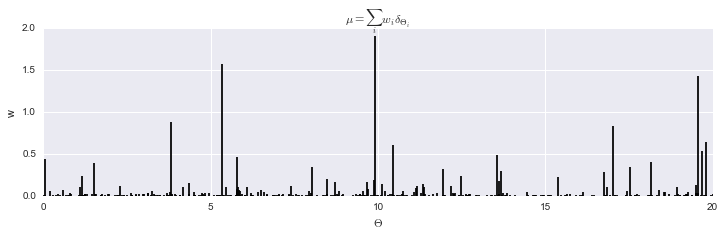

In [8]:
plt.figure(figsize=(12,3))
plt.vlines(thetas, ymin=0, ymax=w)
plt.xlabel('$\Theta$')
plt.ylabel('w')
plt.title('$\mu = \sum_i w_i \delta_{\Theta_i}$')

As you can see the figure, most of the atoms have very small weight, but some atoms have large weight (>.5)

# Simulating Block-structured Sparse Graph

We will simulate block-structred sparse graph suggested by Herlau, T. et al.

Reference: Herlau, T., Schmidt, M. N., & Mørup, M. (2015). Completely random measures for modelling block-structured networks, (1), 1–15. Retrieved from http://arxiv.org/abs/1507.02925

## Sample a graph with 4-blocks having predefined interaction rate

eta = interaction rate between blocks. large value shows high interaction rate between two blocks.

In [9]:
K = 4
alpha = 20.
tau = 1.
sigma = 0.5
eta = (1.,1.)
eta = np.array([[10, 500, 10, 500],[500, 10, 500, 10],[10, 500, 10, 500],[500, 10, 500, 10]])
BG, w, w_rem, alpha, sigma, tau, eta, group, icount = BSgraphrnd(alpha, sigma, tau, K, eta, K*2.)
g = BG.toarray() > 0

### Basic stat of random graph

In [10]:
print("Graph size = ", BG.shape)
print("Total Edge Count =", BG.sum())

Graph size =  (3930, 3930)
Total Edge Count = 123608.0


Sort nodes according to block assignment

In [11]:
#g_base_idx = [i[0] for i in sorted(enumerate(group), key=itemgetter(1))]
idx = [x for x in enumerate(group)]
np.random.shuffle(idx)
g_base_idx = [i[0] for i in sorted(idx, key=itemgetter(1))]
sorted_g = g[np.ix_(g_base_idx, g_base_idx)]

number of nodes for each block

In [12]:
g_node = [np.sum(group == k) for k in range(K)]
g_idx = np.cumsum(g_node)
print(g_node)

[1338, 1099, 837, 656]


### Plot Sampled Graph

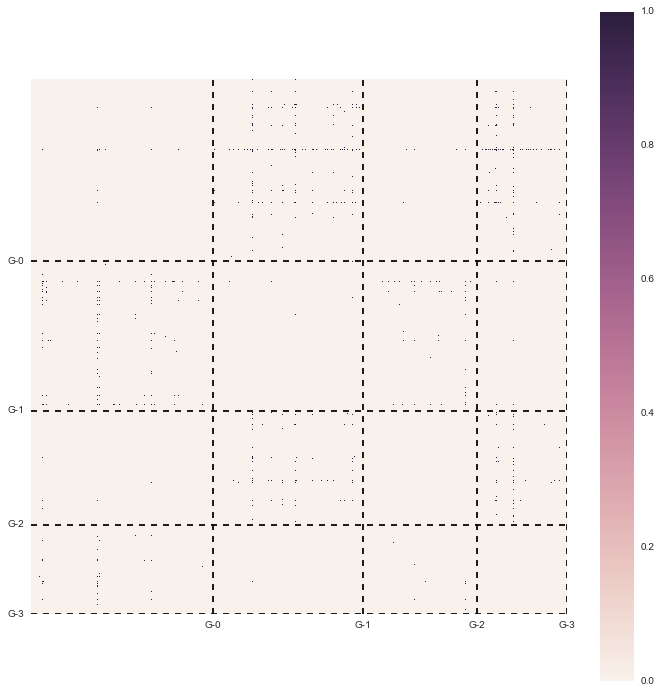

In [13]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(sorted_g, square=True, xticklabels=False, yticklabels=False)
ax.set_xticks(g_idx)
ax.set_xticklabels(['G-%d' % d for d in range(K)])
ax.set_yticks(g_idx[-1] - g_idx)
ax.set_yticklabels(['G-%d' % d for d in range(K)])
ax.hlines(g_idx[-1] - g_idx, xmin=0, xmax=g_idx[-1], linestyles='dashed')
ax.vlines(g_idx, ymin=0, ymax=g_idx[-1], linestyles='dashed')

In the above figure, verticies has been sorted according to their block assignments.

### Interaction between blocks

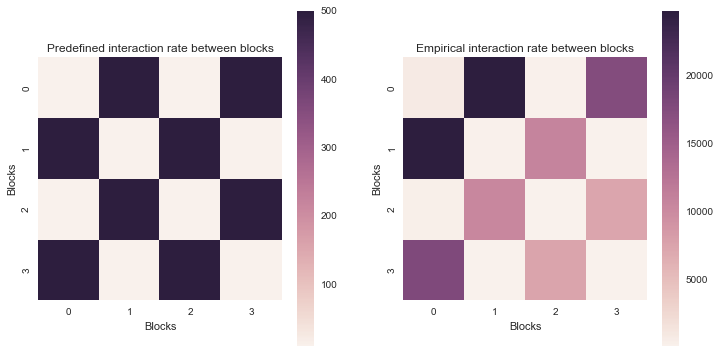

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ax = sns.heatmap(eta, square=True)
ax.set_xlabel('Blocks');ax.set_ylabel('Blocks')
ax.set_title('Predefined interaction rate between blocks')
plt.subplot(1, 2, 2)
ax = sns.heatmap(icount, square=True)
ax.set_xlabel('Blocks');ax.set_ylabel('Blocks')
ax.set_title('Empirical interaction rate between blocks')

Right figure illustrate the interaction parameter used to simulate the graph. Left figure is the number of edges between two groups from the sampled graph. These figure shows more clear interaction patterns between groups.

### Node degree distribution of block graph

(1.0, 1858)

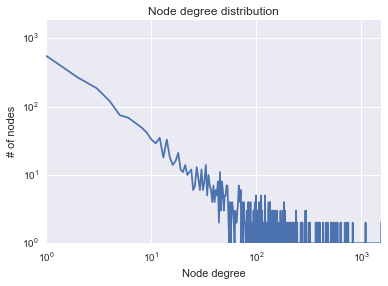

In [15]:
edge_degrees = np.sum(g, 0) + np.sum(g, 1) - np.diag(g)
max_degree = np.max(edge_degrees)
degree_dist = np.array([np.sum(edge_degrees==k) for k in range(1, int(max_degree+1))])

plt.loglog(range(len(degree_dist)), degree_dist+1)
plt.title("Node degree distribution")
plt.ylabel("# of nodes")
plt.xlabel("Node degree")
plt.xlim([0, max_degree])
plt.ylim([0, np.max(degree_dist)])

# Simulating Sparse Graph

We now simulate a sparse graph without any group structures suggested by Caron and Fox.

Reference:Caron, F., & Fox, E. B. (2015). Sparse graphs using exchangeable random measures, 1–64. Retrieved from http://arxiv.org/abs/1401.1137

In [16]:
alpha = 80
G, D, w, w_rem, alpha, sigma, tau = GGPgraphrnd(alpha, sigma, tau)
sg = G.toarray() > 0

Note that G is a symmetric graph. 

Basic stats of the random graph `G`

In [17]:
print("Graph size = ", G.shape)
print("Total Edge Count =", G.sum())

Graph size =  (1805, 1805)
Total Edge Count = 11234.0


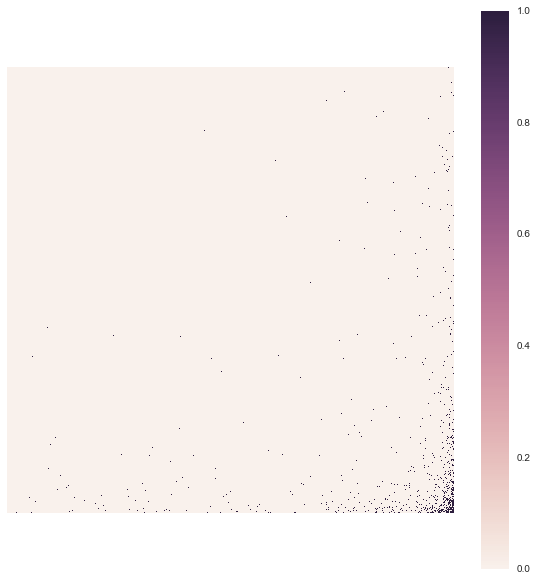

In [18]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(sg, square=True, xticklabels=False, yticklabels=False)

### Node degree distribution of sparse graph

(1.0, 948)

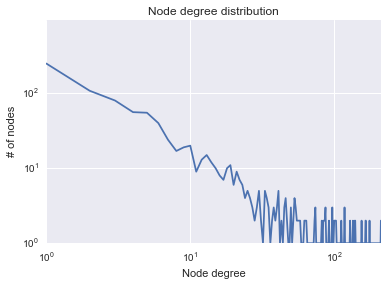

In [19]:
edge_degrees = np.sum(sg, 0)
max_degree = np.max(edge_degrees)
degree_dist = np.array([np.sum(edge_degrees==k) for k in range(1, int(max_degree+1))])

plt.loglog(range(len(degree_dist)), degree_dist+1)
plt.title("Node degree distribution")
plt.ylabel("# of nodes")
plt.xlabel("Node degree")
plt.xlim([0, max_degree])
plt.ylim([0, np.max(degree_dist)])

## Growth rate of random sparse graph

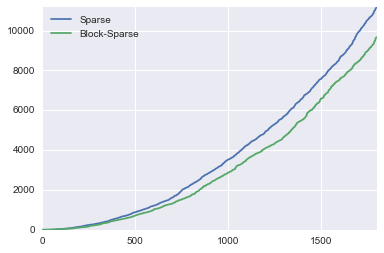

In [20]:
s_rate = compute_growth_rate(G)
b_rate = compute_growth_rate(BG+BG.T)
xlim = min(len(s_rate), len(b_rate)) - 1
ylim = max(s_rate[xlim], b_rate[xlim])
plt.plot(s_rate, label='Sparse')
plt.plot(b_rate, label='Block-Sparse')
plt.xlim((0, xlim))
plt.ylim((0, ylim))
plt.legend(loc='upper left')